In [288]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

In [289]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t")
data_df.columns = ["user_id", "item_id", "rating", "timestamp"]
data_df.drop(columns=["timestamp"], axis=1, inplace=True)
data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
trainset, testset = train_test_split(dataset, 0.2)

In [290]:
item_popularity = {iid: len(ratings) / trainset.n_users for iid, ratings in trainset.ir.items()}

In [305]:
model = UserKNN(k=10, reuse=True)
model.fit(trainset)
predictions = model.test(testset)
print(accuracy.mae(predictions, verbose=False))

privacy_score = dict()
privacy_score_pairwise = np.zeros((trainset.n_users, trainset.n_users))
for alice, secrets in model.known_secrets.items():
    sensitivity = dict()
    for bob, iid in secrets:
        sensitivity_i = np.log(1 / item_popularity[iid])
        sensitivity[bob] = sensitivity.get(bob, 0) + sensitivity_i
    
    for bob, s in sensitivity.items():
        privacy_score[bob] = privacy_score.get(bob, 0) + s
        privacy_score_pairwise[alice, bob] = s

userknn_ps = privacy_score
userknn_sim = model.sim
userknn_scores = np.array(list(privacy_score.values()))

counts, edges = np.histogram(userknn_scores, bins=25)
kde = KernelDensity(bandwidth=100.0, kernel='gaussian')
kde.fit(counts.reshape(-1, 1))
logprob = kde.score_samples(np.linspace(0, np.max(edges), 1000).reshape(-1, 1))
#threshold = np.where(np.abs(np.gradient(np.exp(logprob))) < 1e-7)[0][0]
#threshold = np.linspace(0, np.max(edges), 1000)[np.argmax(np.gradient(np.gradient(np.exp(logprob))))]
threshold = np.linspace(0, np.max(edges), 1000)[np.argmax((np.gradient(np.exp(logprob))))]
threshold

0.9032573503980453


0.0

In [304]:
%matplotlib qt
plt.plot(np.exp(logprob))

In [303]:
np.linspace(0, np.max(edges), 1000)[np.argmax((np.gradient(np.exp(logprob))))]

0.0

In [306]:
model = UserKNN(k=10, reuse=True, tau_2=0.5)
model.fit(trainset)
predictions = model.test(testset)
print(accuracy.mae(predictions, verbose=False))

privacy_score = dict()
privacy_score_pairwise = np.zeros((trainset.n_users, trainset.n_users))
for alice, secrets in model.known_secrets.items():
    sensitivity = dict()
    for bob, iid in secrets:
        sensitivity_i = np.log(1 / item_popularity[iid])
        sensitivity[bob] = sensitivity.get(bob, 0) + sensitivity_i
    
    for bob, s in sensitivity.items():
        privacy_score[bob] = privacy_score.get(bob, 0) + s
        privacy_score_pairwise[alice, bob] = s

reuseknn_ps = privacy_score
reuseknn_sim = model.sim
reuseknn_scores = np.array(list(privacy_score.values()))

0.8982649879111324


In [307]:
np.mean(userknn_scores), np.mean(reuseknn_scores)

(470.44274497622416, 596.2735329470152)

In [308]:
userknn_protected_users = dict()
for uid, score in userknn_ps.items():
    if score > threshold:
        userknn_protected_users[uid] = score

reuseknn_protected_users = dict()
for uid, score in reuseknn_ps.items():
    if score > threshold:
        reuseknn_protected_users[uid] = score

len(userknn_protected_users), len(reuseknn_protected_users)

(943, 744)

In [256]:
df = pd.DataFrame.from_records(list(trainset.all_ratings()), columns=["user_id", "item_id", "rating"])
df.head()

,user_id,item_id,rating
0,0,0,5.0
1,0,53,3.0
2,0,6,5.0
3,0,46,5.0
4,0,503,4.0


[UserKNN] Avg. Nr. of Ratings 93.296599, Avg. Similarity 0.894938
[ReuseKNN] Avg. Nr. of Ratings 177.093333, Avg. Similarity 0.926639


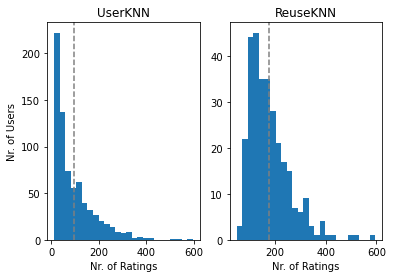

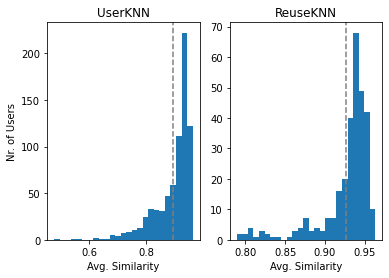

In [287]:
fig1, axes1 = plt.subplots(1, 2, sharey=False, sharex=False)
fig2, axes2 = plt.subplots(1, 2, sharey=False, sharex=False)
dataset_size = []
similarity = []
for uid in userknn_protected_users.keys():
    n_ratings = df.groupby("user_id").size()[uid]
    dataset_size.append(n_ratings)
    
    similarity.append(np.mean(userknn_sim[uid, :]))

axes1[0].hist(dataset_size, bins=25);
axes1[0].axvline(x=np.mean(dataset_size), color="gray", linestyle="dashed")
axes1[0].set_ylabel("Nr. of Users")
axes1[0].set_xlabel("Nr. of Ratings")
axes1[0].set_title("UserKNN")

axes2[0].hist(similarity, bins=25);
axes2[0].axvline(x=np.mean(similarity), color="gray", linestyle="dashed")
axes2[0].set_ylabel("Nr. of Users")
axes2[0].set_xlabel("Avg. Similarity")
axes2[0].set_title("UserKNN")

print("[UserKNN] Avg. Nr. of Ratings %f, Avg. Similarity %f" % (np.mean(dataset_size), np.mean(similarity)))

dataset_size = []
similarity = []
for uid in reuseknn_protected_users.keys():
    n_ratings = df.groupby("user_id").size()[uid]
    dataset_size.append(n_ratings)
    
    similarity.append(np.mean(userknn_sim[uid, :]))
    
axes1[1].hist(dataset_size, bins=25);
axes1[1].axvline(x=np.mean(dataset_size), color="gray", linestyle="dashed")
axes1[1].set_xlabel("Nr. of Ratings")
axes1[1].set_title("ReuseKNN")

axes2[1].hist(similarity, bins=25);
axes2[1].axvline(x=np.mean(similarity), color="gray", linestyle="dashed")
axes2[1].set_xlabel("Avg. Similarity")
axes2[1].set_title("ReuseKNN")

print("[ReuseKNN] Avg. Nr. of Ratings %f, Avg. Similarity %f" % (np.mean(dataset_size), np.mean(similarity)))

[UserKNN] Avg. Nr. of Ratings 54.932692, Avg. Similarity 0.860325
[ReuseKNN] Avg. Nr. of Ratings 41.790047, Avg. Similarity 0.868950


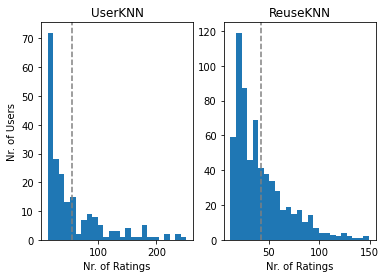

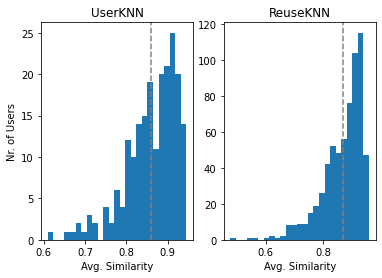

In [286]:
fig1, axes1 = plt.subplots(1, 2, sharey=False, sharex=False)
fig2, axes2 = plt.subplots(1, 2, sharey=False, sharex=False)
dataset_size = []
similarity = []
for uid in set(trainset.all_users()).difference(userknn_protected_users.keys()):
    n_ratings = df.groupby("user_id").size()[uid]
    dataset_size.append(n_ratings)
    
    similarity.append(np.mean(userknn_sim[uid, :]))

axes1[0].hist(dataset_size, bins=25);
axes1[0].axvline(x=np.mean(dataset_size), color="gray", linestyle="dashed")
axes1[0].set_ylabel("Nr. of Users")
axes1[0].set_xlabel("Nr. of Ratings")
axes1[0].set_title("UserKNN")

axes2[0].hist(similarity, bins=25);
axes2[0].axvline(x=np.mean(similarity), color="gray", linestyle="dashed")
axes2[0].set_ylabel("Nr. of Users")
axes2[0].set_xlabel("Avg. Similarity")
axes2[0].set_title("UserKNN")

print("[UserKNN] Avg. Nr. of Ratings %f, Avg. Similarity %f" % (np.mean(dataset_size), np.mean(similarity)))

dataset_size = []
similarity = []
for uid in set(trainset.all_users()).difference(reuseknn_protected_users.keys()):
    n_ratings = df.groupby("user_id").size()[uid]
    dataset_size.append(n_ratings)
    
    similarity.append(np.mean(userknn_sim[uid, :]))
    
axes1[1].hist(dataset_size, bins=25);
axes1[1].axvline(x=np.mean(dataset_size), color="gray", linestyle="dashed")
axes1[1].set_xlabel("Nr. of Ratings")
axes1[1].set_title("ReuseKNN")

axes2[1].hist(similarity, bins=25);
axes2[1].axvline(x=np.mean(similarity), color="gray", linestyle="dashed")
axes2[1].set_xlabel("Avg. Similarity")
axes2[1].set_title("ReuseKNN")

print("[ReuseKNN] Avg. Nr. of Ratings %f, Avg. Similarity %f" % (np.mean(dataset_size), np.mean(similarity)))


In [239]:
userknn_protected_neighbors, reuseknn_protected_neighbors = [], []
for t in range(1, 2000):
    userknn_protected_neighbors.append(len(userknn_scores[userknn_scores > t]))
    reuseknn_protected_neighbors.append(len(reuseknn_scores[reuseknn_scores > t]))

In [240]:
%matplotlib inline

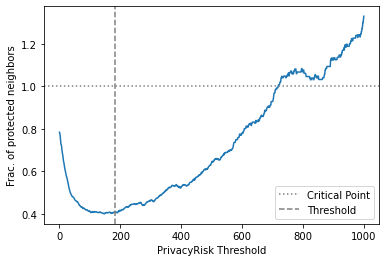

In [241]:
plt.plot((np.array(reuseknn_protected_neighbors) / np.array(userknn_protected_neighbors))[:1000])
plt.ylabel("Frac. of protected neighbors")
plt.xlabel("PrivacyRisk Threshold")
plt.axhline(y=1, color="grey", linestyle="dotted", label="Critical Point")
plt.axvline(x=threshold, color="grey", linestyle="--", label="Threshold")
plt.legend()

In [242]:
threshold = int(threshold)

In [243]:
np.array(reuseknn_protected_neighbors)[threshold] / trainset.n_users, np.array(userknn_protected_neighbors)[threshold] / trainset.n_users

(0.31601272534464475, 0.7783669141039237)

In [244]:
np.mean(userknn_scores[userknn_scores <= threshold]), np.mean(reuseknn_scores[reuseknn_scores <= threshold])

(125.52522375834923, 46.381195106088036)

In [245]:
np.mean(userknn_scores[userknn_scores > threshold]), np.mean(reuseknn_scores[reuseknn_scores > threshold])

(565.8065874201827, 1405.385812146661)